In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, FlattenN, Reshape, ExpandN, SqueezeT
from cosmosis.dataset import SqueezeN, Index, EmbedLookup, AsSparse, AsTensor
from cosmosis.learning import Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder
from learning import Learn

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


loading QM9 datadic from a pickled copy...
CDataset created...
QDataset created...
Data(x=[11, 3], edge_index=[2, 20], edge_attr=[20, 4], y=[1], idx=13, coulomb=[11, 11], distance=[11, 11], adjacency=[11, 11], mulliken=[11, 1], embed1=[29], embed2=[29])


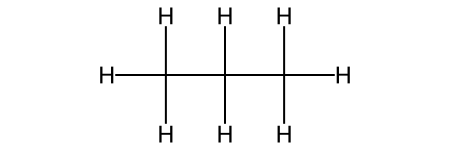

In [2]:
# qchem dataset (QM9) with PyG Data output
# extract, filter, save, transform, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            'edge_attr': ['edge_attr'],
                                            'coulomb': ['coulomb'],
                                            'distance': ['distance'],
                                            'adjacency': ['adjacency'],
                                            'mulliken': ['mulliken'],
                                            'embed1': ['hybridization'],
                                            'embed2': ['chirality'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              'n': 100, #non-random subset for testing,
                              'use_pickle': 'test.pkl', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])
k = qm9.ds_idx[0]
print(qm9[k])
qm9.ds[k].rdmol

In [3]:
# exploring qchem dataset (QM9) 

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['mulliken'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]


longest molecule index:  54  length:  17
shortest molecule index:  14  length:  9


Data(x=[9, 3], edge_index=[2, 16], edge_attr=[16, 4], y=[1], idx=14, coulomb=[9, 9], distance=[9, 9], adjacency=[9, 9], mulliken=[9, 1], embed1=[29], embed2=[29])

shortest molecule


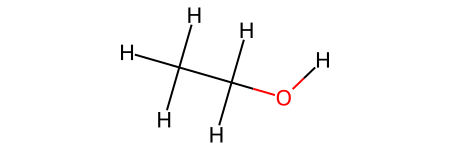

In [4]:
# display qchem dataset (QM9)

print('shortest molecule')
qm9.ds[si].rdmol

longest molecule


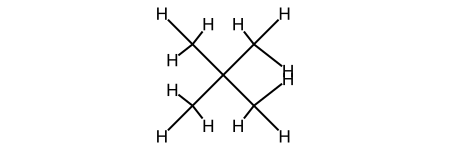

In [5]:
# display qchem dataset (QM9)

print('longest molecule')
qm9.ds[li].rdmol

In [6]:
# qchem dataset (QM9) batch and loader mechanism with pyG Data output
# augmented with rdkit mol data (2.7 GB, 133,885 molecules)
# the preprocessing can be greedy or thrifty to optimize speed or memory
# extract, filter, save, transform, load, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
                                          
ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                             'idx': ['idx'],
                                             'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             'hybridization': ['hybridization'],
                                             'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [SqueezeN(), Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 1000, #non-random subset for testing,
                              #'use_pickle': 'full_ds_3_confs', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])

ds_idx = qm9.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(qm9, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', qm9[1])
print('pgds[1].x: ', qm9[1].x)
print('pgds[1].y: ', qm9[1].y)
print('pgds[1].idx: ', qm9[1].idx)
print('pgds[1].edge_index: ', qm9[1].edge_index)
print('pgds[1].edge_attr: ', qm9[1].edge_attr)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  975
CDataset created...
QDataset created...
batch:  DataBatch(x=[26, 3], edge_index=[2, 52], y=[2], idx=[2], hybridization=[58], chirality=[58], batch=[26], ptr=[3])
batch.ptr:  tensor([ 0, 12, 26])
batch.idx:  tensor([214, 821])
batch.x:  tensor([[6., 1., 3.],
        [6., 1., 3.],
        [6., 1., 3.],
        [6., 1., 3.],
        [6., 1., 3.],
        [6., 1., 3.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [6., 0., 4.],
        [6., 0., 3.],
        [7., 0., 2.],
        [8., 0., 2.],
        [6., 0., 4.],
        [6., 0., 4.],
        [8., 0., 2.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],

In [6]:
# PyG QM9 dataset wrapper PGDS

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

pgds = PGDS(**ds_param['train_param'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


In [7]:
# PyG QM9 dataset wrapper PGDS with dictionary output

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'input_dict': {'x': ['x'],
                                           'y': ['y']},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

pgds = PGDS(**ds_param['train_param'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
{'x': tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), 'y': tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])}


In [2]:
# PyG dataset wrapper (PGDS) batch and loader mechanism
# extract, transform, load, display

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_param = {'train_param': {'dataset': 'QM9',
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': IndexY(7)}}}

pgds = PGDS(**ds_param['train_param'])
ds_idx = pgds.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[43, 11], edge_index=[2, 90], edge_attr=[90, 4], y=[2], pos=[43, 3], z=[43], smiles=[2], name=[2], idx=[2], batch=[43], ptr=[3])
batch.ptr:  tensor([ 0, 22, 43])
batch.idx:  tensor([ 76680, 107008])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
total molecules scanned:  1081
total uncharacterized molecules removed:  23
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  977
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  14470145
running model on gpu...

........final........

total learning time: 0:00:01.801966
test loss: 172.60845947265625


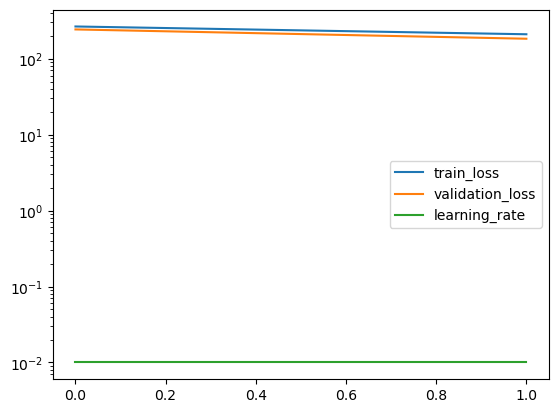

In [3]:
# qchem dataset (QM9) with comosis model (FFNet)
# extract, filter, transform, embed, save, load, model, metrics, display


qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
# cosmosis uses 'X' and 'y' while 'pyg' uses 'x' and 'y'

ds_param = {'train_param': {'input_dict': {'X': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                 'mulliken',
                                                 'coulomb',
                                                  ],
                                             #'idx': ['idx'],
                                             #'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             'hybridization': ['hybridization'],
                                             'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [Pad1d(29), AsTensor()],
                                             'aromatic': [Pad1d(29), AsTensor()],
                                             'degree': [Pad1d(29), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              'n': 1000, #non-random subset for testing,
                              #'use_pickle': 'n_atoms_greater_than_8_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': False}}

model_param = {'in_channels': 29+29+29+29+29*29+29*8+29*8,
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel',
               'embed_param': {
                               'hybridization': (9,8,0,True),
                               'chirality': (4,8,0,True),
                               'flatten': True,
                               }
              }

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013} #early stopping when lr is =<

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15),
                #'subset': .1, #create random subset
                }

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125} #plateau at this value

opt_param = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=128, epochs=2, save_model=False)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  63041
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  336833
running model on gpu...

.....................

total elapsed time: 0:00:05.869349
epoch: 0
y_pred:  tensor([-92.8516], device='cuda:0')
y:  tensor([-11917.2588], device='cuda:0')
train loss: 125482831.54929577, val loss: 124189305.6
lr: 0.01

.....................

total elapsed time: 0:00:11.146869
epoch: 1
y_pred:  tensor([-321.4677], device='cuda:0')
y:  tensor([-11339.6973], device='cuda:0')
train loss: 122822142.42253521, val loss: 120091419.2
lr: 0.01

.....................

total elapsed time: 0:00:16.383201
epoch: 2
y_pred:  tensor([-523.0908], device='cuda:0')
y:  

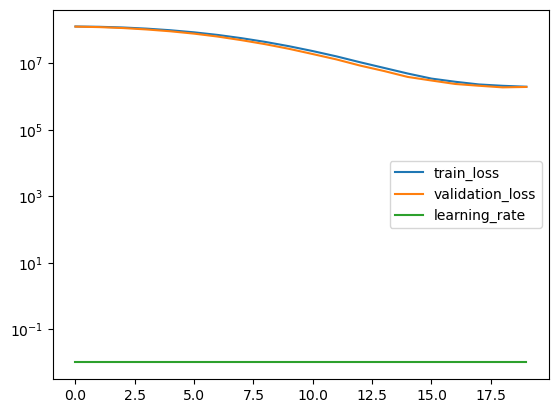

In [4]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNet)
# NetConv convolutions with edge features
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y.unsqueeze(0)
        return data

model_param = {'in_channels': 11, 
               'hidden': 128, 
               'out_channels': 1,
               'depth': 2,
               'convolution': 'NetConv', # uses edge features
               'pool': 'MeanAggregation',
               'dropout': .1,
               'activation': 'relu',
               'edge_features': 4,
               }

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 1,
                 'log_plot': True,
                 'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'subset': .1,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, batch_size=128, epochs=20)

# cosmosis qm9 feature U0 is in hartree while pyg qm9 U0 (y[7]) is in eV 
# hartree * 27.2114 = eV

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  248961
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  517505
running model on gpu...

.....................

total elapsed time: 0:00:03.231369
epoch: 0
y_pred:  tensor([-107.0207], device='cuda:0')
y:  tensor([-10802.8037], device='cuda:0')
train loss: 124928545.91549295, val loss: 122723406.4
lr: 0.01

.....................

total elapsed time: 0:00:04.799940
epoch: 1
y_pred:  tensor([-8.5800], device='cuda:0')
y:  tensor([-10429.2148], device='cuda:0')
train loss: 119650474.25352113, val loss: 114610152.53333333
lr: 0.01

.....................

total elapsed time: 0:00:06.261476
epoch: 2
y_pred:  tensor([-1433.9529], device='cuda:

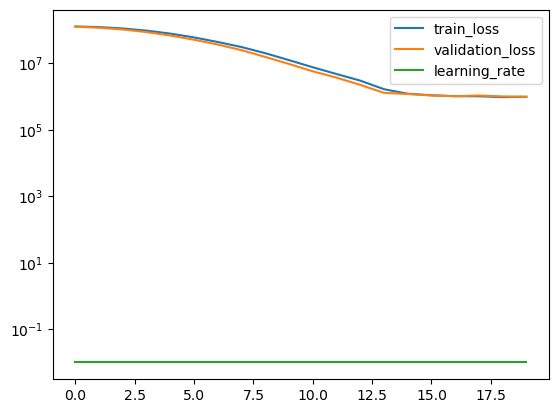

In [5]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNet)
# SAGEConv convolutions
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y.unsqueeze(0)
        return data

model_param = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'activation': 'relu'}

ds_param = {'train_param': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_param': {'root': './data/pyg/qm9/',
                                           'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 1,
                 'log_plot': True,
                 'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'subset': .1,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, batch_size=128, epochs=20)

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9901
total molecules scanned:  10100
total uncharacterized molecules removed:  269
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  9731
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  248961
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  513409
running model on gpu...

.....................

total elapsed time: 0:00:11.085880
epoch: 8
y_pred:  tensor([-427.2441], device='cuda:0')
y:  tensor([-344.4546], device='cuda:0')
train loss: 1726.7257379495873, val loss: 1915.2880637428977
lr: 0.01

.....................

total elapsed time: 0:00:21.182057
epo

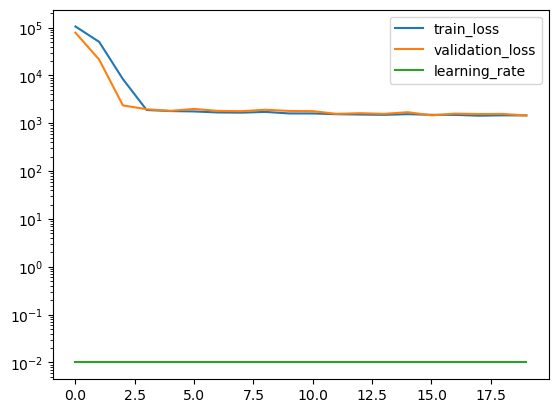

model: 20250320_1308 saved...


In [2]:
# qchem dataset (QM9) with qchem model (GraphNet)
# extract, filter, transform, embed, save, load, model, metrics, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                             'idx': ['idx'],
                                             'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             #'hybridization': ['hybridization'],
                                             #'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [ExpandN(0), AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              'n': 10000, # non-random subset for testing,
                              'use_pickle': False,
                              'n_conformers': 3,
                              'dict2data': True}}

model_param = {'in_channels': 3, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'activation': 'relu',
               }

metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 10,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=128, epochs=20, save_model=True, load_model=None)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  4768
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  7264
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  4768
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  4768
GraphNetVariationalEncoder loaded...
default weight initialization...
GraphNetVariationalEncoder model loaded...
number of model parameters:  16800
running model on gpu...

.....................

total elapsed time: 0:00:21.913572
epoch: 0
y_pred:  tensor(1., device='cuda:0')
y:  tensor(0., device='cuda:0')
train loss: 2.833225721248428, val loss: 2.419594975336929
lr: 0.00

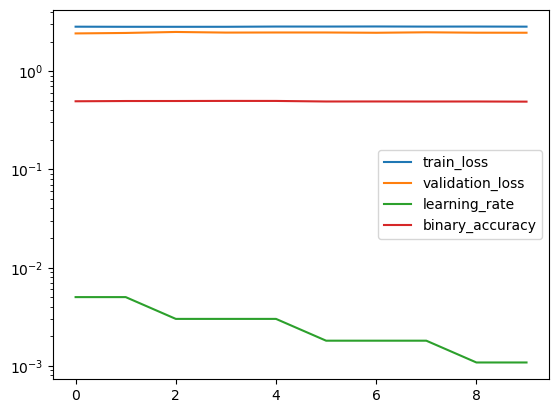

In [2]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNetVariationalEncoder)
# graph variational autoencoder WITHOUT adversarial regulation and GCNConv encoder
# extract, load, model, metrics, display

model_param = {'in_channels': 11, 
               'hidden': 32, 
               'out_channels': 32,
               'depth': 2,
               'pool': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

metrics_param = {'report_interval': 1,
                 'log_plot': True,
                 'min_lr': .001,
                 'metric_name': 'binary_accuracy',
                 'metric_param': {}}

opt_param = {'lr': 0.005}

crit_param = {'adversarial': False,
              'disc_param': {'in_channels': 32, 'hidden': 64, 'out_channels': 32}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': .1}

sched_param = {'factor': .6,
               'patience': 1,
               'cooldown': 1,
               'min_lr': .0005}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, batch_size=12, epochs=10, target=None)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  4768
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  7264
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  4768
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  4768
GraphNetVariationalEncoder loaded...
default weight initialization...
GraphNetVariationalEncoder model loaded...
number of model parameters:  16800
running model on gpu...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  15136

.....................

total elapsed time: 0:00:03.918854
epoch: 0
y_pred:  tensor(nan, device='cu

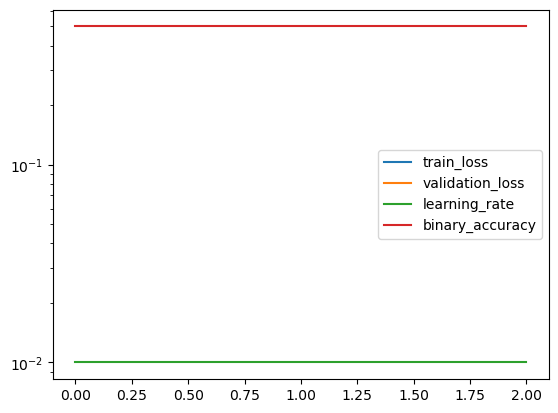

In [5]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNetVariationalEncoder)
# graph variational autoencoder WITH adversarial regulation and GCNConv encoder
# extract, load, model, metrics, display

model_param = {'in_channels': 11, 
               'hidden': 32, 
               'out_channels': 32,
               'depth': 2,
               'pool': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

metrics_param = {'report_interval': 1,
                 'log_plot': True,
                 'min_lr': .0013,
                 'metric_name': 'binary_accuracy',
                 'metric_param': {}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': True,
              'disc_param': {'in_channels': 32, 'hidden': 64, 'out_channels': 32}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': 0.01}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=12, epochs=3)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  248961
pytorch geometric model GraphSAGE loaded...
running model on gpu...

.....................

total elapsed time: 0:00:29.352497
epoch: 0
y_pred:  tensor([-2980.7544], device='cuda:0')
y:  tensor([-9932.5615], device='cuda:0')
train loss: 103629838.89075631, val loss: 65219387.15789474
lr: 0.01

.....................

total elapsed time: 0:00:41.230259
epoch: 1
y_pred:  tensor([-10721.4414], device='cuda:0')
y:  tensor([-12353.7920], device='cuda:0')
train loss: 30445393.582633052, val loss: 7394007.486842105
lr: 0.01

........final........

total learning time: 0:00:46.473561
test loss: 7331827.118421053


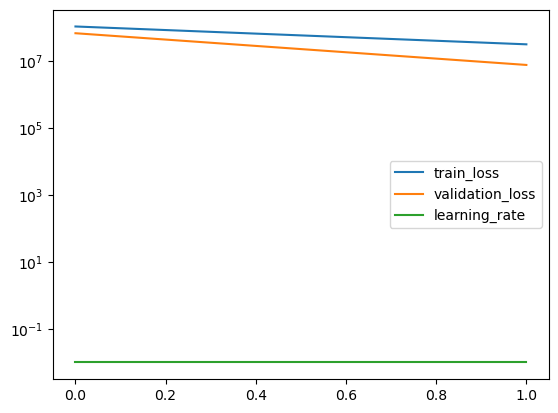

In [4]:
# qchem PyG dataset wrapper (PGDS) with qchem PyG model wrapper (PygModel)
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y.unsqueeze(0)
        return data

model_param = {'model_name': 'GraphSAGE',
               'pool': 'MeanAggregation',
               'ffnet': True,
               'in_channels': 256, # ffnet param
               'hidden': 256, 
               'out_channels': 1, 
               'pyg_param': {'in_channels': 11, # GraphSAGE param
                             'hidden_channels': 256,
                             'num_layers': 2,
                             'out_channels': 256,
                             'dropout': .1,
                             'norm': 'BatchNorm'}}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=2)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  890625
running model on gpu...

.....................

total elapsed time: 0:00:03.509517
epoch: 0
y_pred:  tensor([-97.9204], device='cuda:0')
y:  tensor([-10362.4590], device='cuda:0')
train loss: 125240138.28571428, val loss: 123832284.57142857
lr: 0.01

.....................

total elapsed time: 0:00:05.648712
epoch: 1
y_pred:  tensor([-471.6337], device='cuda:0')
y:  tensor([-11947.0088], device='cuda:0')
train loss: 122110203.42857143, val loss: 119569742.85714285
lr: 0.01

.....................

total elapsed time: 0:00:07.578859
epoch: 2
y_pred:  tensor([-42.0468], device='cuda:0')
y:  tensor([-11003.1104], device='cuda:0')
train loss: 116810318.17142858, val loss: 112889629.71428572
lr: 0.01

........final........

total learning time: 0:00:08.177665
test loss: 113030450.28571428


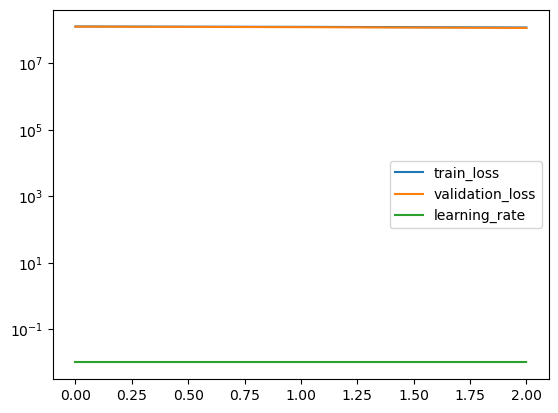

In [4]:
# qchem PyG dataset wrapper (PGDS) with cosmosis model (FFNet)
# dictionary output
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}
#qchem model keys are 'X' and 'y' while pyg used 'x' and 'y'
ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {'y': [Index(7)],
                                           'x': [FlattenN(), Pad1d(29*11)]},
                            'input_dict': {'X': ['x'], 
                                           'y': ['y']},
                            'pg_param': {'root': './data/pyg/qm9/'}}}

metrics_param = {'report_interval': 1,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'subset': .1,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}



l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=3)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.710742
epoch: 0, lr: 0.01
train loss: 1487.350495990954, val loss: 1401.3312683105469
last 5 targets: 
[-1809.1  -1455.85 -1556.54 -1301.34 -1790.14]
last 5 predictions: 
[-136.85376 -145.0191  -134.02736 -143.30127 -127.97264]

...........................
learning time: 0:00:02.429880
epoch: 10, lr: 0.01
train loss: 47.646341825786386, val loss: 45.67989253997803
last 5 targets: 
[-1285.83 -1591.66 -1587.14 -1356.81 -1700.7 ]
last 5 predictions: 
[-1324.9489 -1502.5898 -1560.6912 -1424.8046 -1707.5858]

...........................
learning time: 0:00:04.088477
epoch: 20, lr: 0.01
train loss: 39.34627854196649, val loss: 38.61621570587158
last 5 targets: 
[-1718.83 -1227.48 -1505.95 -1628.37 -1374.26]
last 5 predictions: 
[-1674.3522 -1319.6182 -1544.477  -1594.6635 -1384.1388]

...........................
learning time: 0:00:05.762007
epoch: 30, lr: 0.

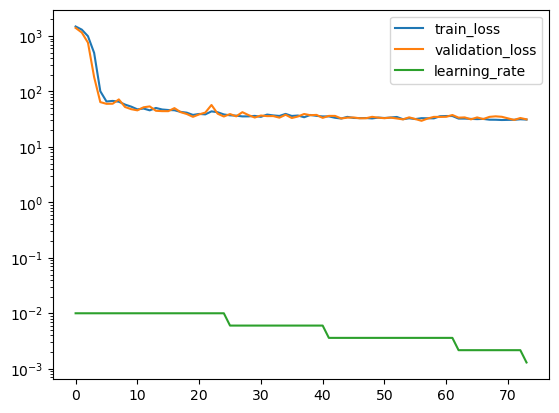

In [2]:
# qchem dataset (QM7) and cosmosis model (FFNet)
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 23*23, 
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['ae']},
                            'in_file': './data/qm7/qm7.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=200)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.287899
epoch: 0, lr: 0.01
train loss: 1515.2149593955592, val loss: 1431.9375915527344
last 5 targets: 
[-1918.446  -1878.0168 -1636.8151 -1578.769  -1432.4517]
last 5 predictions: 
[-161.34067 -147.25433 -155.94202 -127.43952 -120.78729]

...........................
learning time: 0:00:01.922052
epoch: 10, lr: 0.01
train loss: 68.95001562018143, val loss: 69.59542274475098
last 5 targets: 
[-1516.0977 -1735.5308 -1887.9491 -1618.9104 -1871.8513]
last 5 predictions: 
[-1457.3131 -1572.8724 -1806.8488 -1615.0402 -1890.35  ]

...........................
learning time: 0:00:03.543926
epoch: 20, lr: 0.01
train loss: 50.41412453902395, val loss: 60.88741970062256
last 5 targets: 
[-1475.3118 -1526.9512 -1569.5222 -1275.571  -1624.2003]
last 5 predictions: 
[-1384.9757 -1497.2284 -1492.5524 -1300.3011 -1636.5834]

...........................
learning time: 0:

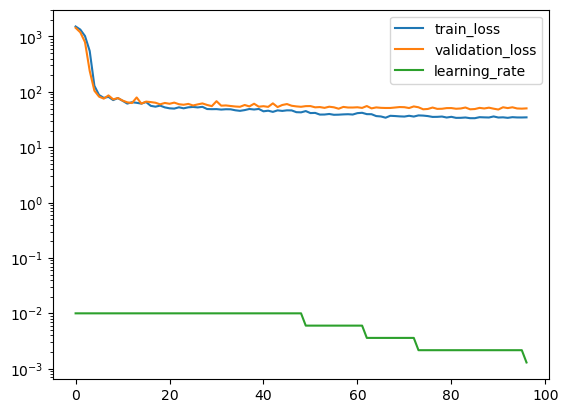

In [3]:
# qchem dataset (QM7b) and cosmosis model (FFNet)
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['E']},
                            'in_file': './data/qm7b/qm7b.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, 
          batch_size=256, epochs=200)

In [2]:
# exploring qchem dataset (QM7X)

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_param = {'train_param': {'input_dict': {'X': ['atNUM'],
                                           'y': ['eAT']},
                            'transforms': {},
                            'n': 100, #non-random subset for testing
                            'selector': ['opt']}}

qm7x = QM7X(**ds_param['train_param'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  100
total molecular structures (idconf) mapped:  223
CDataset created...
QDataset created...
longest molecule length:  16  index:  102
(16,)


{'X': array([6., 6., 6., 6., 7., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32),
 'y': array([68.53037], dtype=float32)}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  12643329
running model on gpu...

........final........

total learning time: 0:00:00.303066
test loss: 28.2710018157959


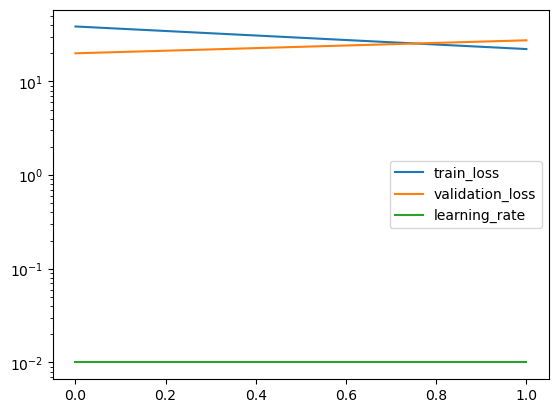

In [5]:
# qchem dataset (QM7X) and cosmosis model (FFNet)
# extract, filter, transform, load, model, metrics, display

model_param = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['eAT']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d(23*23)]},
                            'selector': ['opt'],
                            'n': 1000, #non-random subset for testing
                             }}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=128, epochs=2)

In [4]:
# qchem dataset (ANI1x) with PyG Data output
# extract, filter, transform, display

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': True}}

ani1x = ANI1x(**ds_param['train_param'])
k = ani1x.ds_idx[0]
print(k)
ani1x[k]

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
C10H10


Data(y=[1], X=[3969])

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:01.025570
epoch: 0, lr: 0.01
train loss: 457.241330315085, val loss: 272.0874285016741
last 5 targets: 
[-488.59094 -284.0237  -551.09576 -345.46924 -536.93677]
last 5 predictions: 
[-252.55856 -194.68886 -240.05179 -245.94324 -381.75403]

...........................
learning time: 0:00:09.130123
epoch: 10, lr: 0.01
train loss: 33.37232191422407, val loss: 33.349958419799805
last 5 targets: 
[-384.468   -727.51483 -509.34915 -681.5662  -744.225  ]
last 5 predictions: 
[-392.8709  -759.2792  -503.0849  -691.566   -758.63165]
test loss: 30.854946408952987

...........................
learning time: 0:00:16.542758
last 5 targets: 
[-667.136   -604.81476 -457.28925 -119.05935 -627.7167 ]
last 5 predictions: 
[-662.626   -594.46515 -449.2103  -154

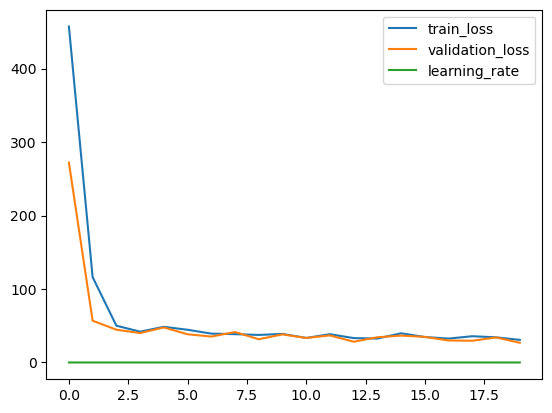

In [5]:
# qchem dataset (ANI1x) and comosis model (FFNet)
# extract, filter, transform, load, model, metrics, display

model_param = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': False}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}

opt_param = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          batch_size=64, epochs=20)